<a href="https://colab.research.google.com/github/mahendra-gehlot/CP260/blob/main/Vision_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Assignment 2: Perspective Transform and Camera Pose

- Segment  all  the  3  objects  using  color  thresholding and  calculate  theircentroidsin  the image.
- Write  down  the  equations that  relate  the  centroids  of objects  in the  image  with  the corresponding world coordinates.
- Estimate the depth of each object in the camera coordinate system by using the known values of the radii of the objects.
- Use a suitable non-linear solver to solve the system of equations.
- Report the final pose of the camerafor each of the given images.



### Import all the necessary library packages 

In [ ]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import math
import cv2

### Utility functions to estimate the object centers using color thresholding 

In [ ]:
def erode_dilate(image):
    """
    Function to perform morphological operations to fill the 'holes' in the threshold image
    """
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.erode(image, kernel, iterations=1)
    img_dilation = cv2.dilate(img_erosion, kernel, iterations=2)

    return img_dilation

In [ ]:
def get_centroid_util(threshold_img):
    """
    Function to obtain the largest contour and calculate the centroid of that contour
    Returns the tuple consisting the x and y coordinates of the contour
    """
    contours, hierarchy = cv2.findContours(threshold_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cx = 0
    cy = 0
    radius = 0
    if len(contours) != 0:
        # find the biggest contour (c) by the area
        c = max(contours, key=cv2.contourArea)

        # compute the center of the contour
        m = cv2.moments(c)
        cx = int(m["m10"] / m["m00"])
        cy = int(m["m01"] / m["m00"])

        area = cv2.contourArea(c)
        radius = math.sqrt(area/math.pi)

    return cx, cy, radius

In [ ]:
def plot_center(image, cx, cy):
    """
        Function to plot the calculated center of the 3 objects
    """
    cv2.circle(image, (cx, cy), 7, (255, 255, 255), -1)
    return image

In [ ]:
def get_centroids(input_img):
    """
        Function to estimate the centroids of the 3 objects
        input_img: The input RGB image, consisting the 3 different colored objects
        returns a tuple of x, y coordinates of the 3 objects
    """  
    mask1 = cv2.inRange(input_img, (90, 0, 0), (255, 90, 90))
    plt.imshow(mask1, cmap="gray")
    plt.show()
    
    mask2 = cv2.inRange(input_img, (0, 90, 0), (100, 255, 100))
    plt.imshow(mask2, cmap="gray")
    plt.show()

    mask3 = cv2.inRange(input_img, (0, 0, 90), (60, 60, 255))
    plt.imshow(mask3, cmap="gray")
    plt.show()

    mask1 = erode_dilate(mask1)
    red_cx, red_cy, red_radius = get_centroid_util(mask1)    
    print("Center of the red ball: x={}px   y={}px and radius={}px".format(red_cx, red_cy, red_radius))
    input_img = plot_center(input_img, red_cx, red_cy)
    
    mask2 = erode_dilate(mask2)
    green_cx, green_cy, green_radius = get_centroid_util(mask2)    
    print("Center of the green ball: x={}px   y={}px and radius={}px".format(green_cx, green_cy, green_radius))
    input_img = plot_center(input_img, green_cx, green_cy)
    
    mask3 = erode_dilate(mask3)
    blue_cx, blue_cy, blue_radius = get_centroid_util(mask3)    
    print("Center of the blue ball: x={}px   y={}px and radius={}px".format(blue_cx, blue_cy, blue_radius))
    input_img = plot_center(input_img, blue_cx, blue_cy)
    

    return input_img

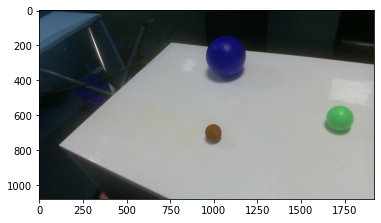

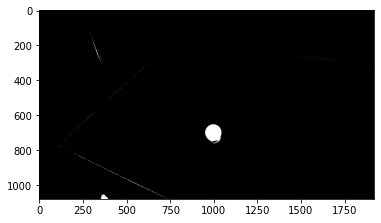

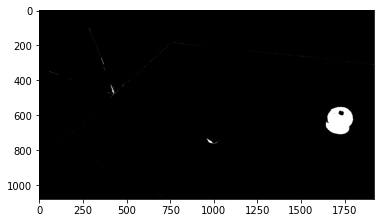

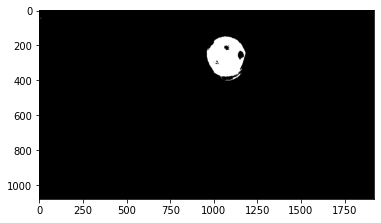

Center of the red ball: x=999px   y=701px and radius=50.08275055473961px
Center of the green ball: x=1721px   y=631px and radius=79.57473572594601px
Center of the blue ball: x=1072px   y=267px and radius=113.57109690848493px


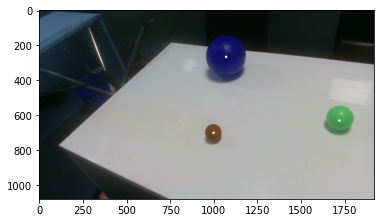

In [ ]:
input_image = cv2.imread("Image1.png")
plt.imshow(input_image)
plt.show()
centroid_image = get_centroids(input_img=input_image)
plt.imshow(centroid_image)

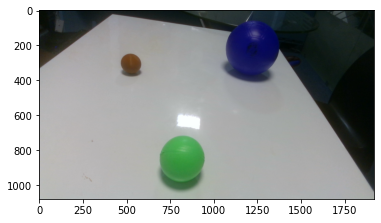

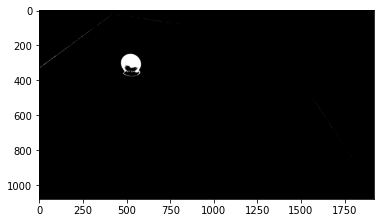

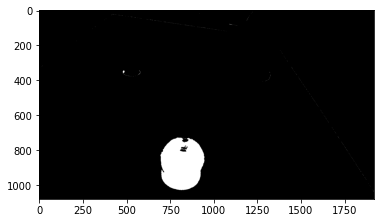

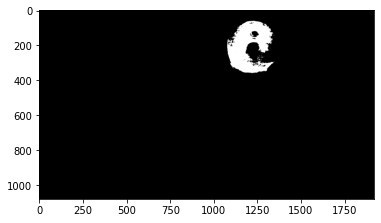

Center of the red ball: x=527px   y=297px and radius=53.19413250755018px
Center of the green ball: x=818px   y=878px and radius=140.26495143189132px
Center of the blue ball: x=1205px   y=208px and radius=126.59237548055225px


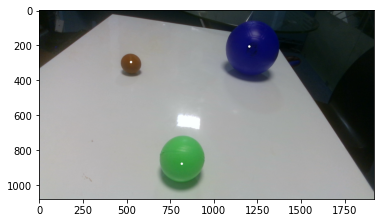

In [ ]:
input_image = cv2.imread("Image2.png")
plt.imshow(input_image)
plt.show()
centroid_image = get_centroids(input_img=input_image)
plt.imshow(centroid_image)

### Utility function to determine the roots of the (non-linear) equations defined by func(x) = 0 given a starting estimate

In [ ]:
def function(p):
    # p is the initial approximation to be provided to fsolve.
    t1 = p[0] # x_pos_guess
    t2 = p[1] # y_pos_guess
    t3 = p[2] # z_pos_guess
    alpha_guess = p[3] # roll_angle
    beta_guess = p[4] # pitch_angle
    gamma_guess = p[5] # yaw_angle
# For balancing requirement of equations and unknown variables, following dummy variable are added
    var_1 = p[6]
    var_2 = p[7]
    var_3 = p[8]
   
#     The below is a sample of one of the Rotation Matrices 
    r11 = np.cos(gamma_guess) * np.cos(beta_guess)
    r12 = np.cos(gamma_guess) * np.sin(beta_guess) * np.sin(alpha_guess) - np.sin(gamma_guess) * np.cos(alpha_guess)
    r13 = np.sin(gamma_guess) * np.sin(alpha_guess) + np.cos(gamma_guess) * np.sin(beta_guess) * np.cos(alpha_guess)
    r21 = np.sin(gamma_guess) * np.cos(beta_guess)
    r22 = np.cos(gamma_guess) * np.cos(alpha_guess) + np.sin(gamma_guess) * np.sin(alpha_guess) * np.sin(beta_guess)
    r23 = np.sin(gamma_guess) * np.sin(beta_guess) * np.cos(alpha_guess) - np.cos(gamma_guess) * np.sin(alpha_guess)
    r31 = - np.sin(beta_guess)
    r32 = np.cos(beta_guess) * np.sin(alpha_guess)
    r33 = np.cos(beta_guess) * np.cos(alpha_guess) 

#     Intrinsic Parameters of the Camera 
    fx = 1399.64
    cx = 944.75
    fy = 1399.64
    cy = 541.54
    
#     Position of the 3 balls in the real world 
    xw_1, yw_1, zw_1 = 170.99, 190.78, 85.46   # red
    xw_2, yw_2, zw_2 = 155.33, 145.99, 81.16   # green
    xw_3, yw_3, zw_3 = 138.99, 176.78, 80.37   # blue
    
#   Position of the 3 balls in the image1, pixel coordinates of the center of the ball 
    x1, y1 = 999, 701
    x2, y2 = 1721, 631
    x3, y3 = 1072, 267

# #   Position of the 3 balls in the image2, pixel coordinates of the center of the ball 
#     x1, y1 = 527, 297
#     x2, y2 = 818, 878
#     x3, y3 = 1205, 208

    # locations/dimesions for image 1
    focal_length = 1399.64
    radius_red_real = 2.55        #radius of blue ball
    radius_red_pix = 50.08275055473961        #radius of blue ball in image 
    radius_green_real = 3.34       #radius of green ball
    radius_green_pix = 79.57473572594601      #radius of green ball in image
    radius_blue_real = 7.64         #radius of red ball
    radius_blue_pix = 113.57109690848493        #radius of red ball in image

    # #locations/dimesions for image 2
    # focal_length = 1399.64
    # radius_red_real = 2.55        #radius of blue ball
    # radius_red_pix = 53.19413250755018        #radius of blue ball in image 
    # radius_green_real = 3.34       #radius of green ball
    # radius_green_pix = 140.26495143189132      #radius of green ball in image
    # radius_blue_real = 7.64         #radius of red ball
    # radius_blue_pix = 126.59237548055225        #radius of red ball in image



#     Distance Relation given by Perspective Transform
    zc_1 = (focal_length * radius_red_real)/radius_red_pix

    zc_2 = (focal_length * radius_green_real)/radius_green_pix

    zc_3 = (focal_length * radius_blue_real)/radius_blue_pix

    F = np.empty(9)

#     Equation for Red Ball
    F[0] = (fx * r11 + cx * r31) * (xw_1 - t1) + (fx * r12 + cx * r32) * (yw_1 - t2) + (fx * r13 + cx * r33) * (
                zw_1 - t3) - x1 * zc_1
    F[1] = (fx * r21 + cx * r31) * (xw_1 - t1) + (fx * r22 + cx * r32) * (yw_1 - t2) + (fx * r23 + cx * r33) * (
                zw_1 - t3) - y1 * zc_1
    F[2] = (xw_1 - t1) * r31 + (yw_1 - t2) * r32 + (zw_1 - t3) * r33 - zc_1

#     Equation for Green Ball
    F[3] =(fx * r11 + cx * r31) * (xw_2 - t1) + (fx * r12 + cx * r32) * (yw_2 - t2) + (fx * r13 + cx * r33) * (
                zw_2 - t3) - x2 * zc_2
    F[4] = (fx * r21 + cx * r31) * (xw_2 - t1) + (fx * r22 + cx * r32) * (yw_2 - t2) + (fx * r23 + cx * r33) * (
                zw_2 - t3) - y2 * zc_3
    F[5] = (xw_2 - t1) * r31 + (yw_2 - t2) * r32 + (zw_2 - t3) * r33 - zc_2
    
#     Equation for Blue Ball
    F[6] =(fx * r11 + cx * r31) * (xw_3 - t1) + (fx * r12 + cx * r32) * (yw_3 - t2) + (fx * r13 + cx * r33) * (
                zw_3 - t3) - x3 * zc_3
    F[7] = (fx * r21 + cx * r31) * (xw_3 - t1) + (fx * r22 + cx * r32) * (yw_3 - t2) + (fx * r23 + cx * r33) * (
                zw_3 - t3) - y3 * zc_3
    F[8] = (xw_3 - t1) * r31 + (yw_3 - t2) * r32 + (zw_3 - t3) * r33 - zc_3
    
    return F

In [ ]:
# Image 1 Implementation with a random initialisation 
root = fsolve(function, np.array([100, 150, 130, -150, 50, 150, 0, 0, 0]), maxfev=500, factor=0.5)

print(root)
print("/n")


[ 7.31409786e+01  1.75737542e+02  5.16592413e+01 -1.48647433e+02
  4.85765306e+01  1.50684605e+02  6.24524392e+21 -1.37885519e+22
 -2.34557861e+22]
/n


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [ ]:
# Image 2 Implementation with a random initialisation 
# enable value of image2 from function by uncommenting image 1 data.
root = fsolve(function, np.array([100, 150, 130, -150, 50, 150, 0, 0, 0]), maxfev=500, factor=0.5)

print(root)
print("/n")



[ 1.91499614e+02  1.87332380e+02  9.78688838e+01 -1.49631686e+02
  5.25602613e+01  1.49909681e+02  9.43954528e+19  8.38971286e+19
  2.65619144e+19]
/n


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
